In [1]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 45.0 MB/s eta 0:00:00


In [2]:
import torch
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torchvision.models as models
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
from torch.optim.lr_scheduler import OneCycleLR
import torch.optim as optim
from pytorch_lightning.callbacks import LearningRateMonitor

In [3]:
class ResNet18Encoder(nn.Module):
    def __init__(self, input_channels, z_dim):
        super(ResNet18Encoder, self).__init__()

        # Load the pre-trained ResNet18 model
        resnet18 = models.resnet18(pretrained=True)
        if input_channels != 3:
            # Modify the first layer to accept the new number of input channels
            resnet18.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the final classification layer
        modules = list(resnet18.children())[:-1]
        self.resnet18 = nn.Sequential(*modules)

    def forward(self, x):
        # Forward pass through ResNet18 layers
        x = self.resnet18(x)
        x = x.view(x.shape[0], -1)
        return x


class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x


class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class ResNet18Decoder(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=5):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = nn.Conv2d(64, nc, 3, stride=1, padding=1)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 5, 32, 32)
        return x
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        logits = self.softmax(x)
#         label = torch.argmax(logits, dim=1)
        return logits

In [4]:
class VAE(pl.LightningModule):
    def __init__(self, latent_dim=256):

        super().__init__()

        # encoder layers
        self.encResnet18 = ResNet18Encoder(5 ,latent_dim)

        # Add custom fully connected layers for mu and logvar
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # decoder layers
        self.decResnet18 = ResNet18Decoder(z_dim=latent_dim)

        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

        self.classifier   = MLPClassifier(32*32*3, 512, 10)
        # classifier loss
        self.bce_loss = nn.BCELoss(reduction = 'none')


#     def classifier(self, x):
# #         x = F.relu(self.chConv1(x))
#         x = x.view(x.shape[0],-1)
#         x = F.sigmoid(self.chout(x))
#         return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        scheduler = OneCycleLR(
                optimizer,
                max_lr= 10**-3,
                pct_start = 5/self.trainer.max_epochs,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=len(train_dataloader),
                div_factor=100,
                three_phase=False,
                final_div_factor=100,
                anneal_strategy='linear'
            )
        return {
             "optimizer": optimizer,
             "lr_scheduler": {"scheduler": scheduler, "interval": "step"},
             }

    def kl_divergence(self,z,mu,std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def gaussian_likelihood(self,mean,logscale,sample):
        scale   = torch.exp(logscale)
        dist    = torch.distributions.Normal(mean,scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1,2,3))

    def forward(self,x):
        # encoder
        x_encoded = self.encResnet18(x)
        mu = self.fc_mu(x_encoded)
        log_var = self.fc_logvar(x_encoded)
        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()

        # decoder
        x_decoder = self.decResnet18(z)

        # multi label classifier
        x_label = self.classifier(x_decoder[:, -3:, :, :])

        return x_decoder, x_label,z, mu, std


    def classification_loss(self,x, y):
        ml_loss = self.bce_loss(x, y).sum(dim=1)
        return ml_loss

    def training_step(self,batch,batch_idx):

        train_x, y, y_changed = batch['images'], batch['correct_labels'], batch['changed_labels']

        # forward pass thru model
        x_hat, x_label, z, mu, std = self(train_x)

        # vae loss
        recon_loss = self.gaussian_likelihood(x_hat[:, -3:, :, :], self.log_scale, train_x[:, -3:, :, :])
        kl = self.kl_divergence(z, mu, std)
        elbo = kl - recon_loss

        # combine y and y changed before sending to bce loss
        y = F.one_hot(y, num_classes = 10).float()
        y_changed = F.one_hot(y_changed, num_classes = 10).float()
        ml_loss_corrected = self.classification_loss(x_label, y)
        ml_loss_changed = self.classification_loss(x_label, y_changed)
        total_loss = (0.4 * ml_loss_corrected)+ (0.4 * ml_loss_changed) + (0.2 * elbo)
#         total_loss = elbo.mean()

        total_loss = total_loss.mean()
#         print(total_loss)

        self.log_dict({
            'elbo': (0.01 * elbo).mean(),
            'kl': kl.mean(),
            'classifier loss':(ml_loss_corrected+ml_loss_changed).mean(),
            'total training loss':total_loss
        })
        return total_loss

    def validation_step(self,batch,batch_idx):

        x, y, y_changed = batch['images'], batch['correct_labels'], batch['changed_labels']

        # forward pass thru model
        x_hat, x_label, z, mu, std = self(x)
        # vae loss
        recon_loss = self.gaussian_likelihood(x_hat[:, -3:, :, :], self.log_scale, x[:,-3:,:,:])
        kl = self.kl_divergence(z, mu, std)
        elbo = kl - recon_loss

        # combine y and y changed before sending to bce loss
        y = F.one_hot(y, num_classes = 10).float()
        y_changed = F.one_hot(y_changed, num_classes = 10).float()
        ml_loss_corrected = self.classification_loss(x_label, y)
        ml_loss_changed = self.classification_loss(x_label, y_changed)
        val_loss = (0.4 * ml_loss_corrected)+ (0.4 * ml_loss_changed) + (0.2 * elbo)
        val_loss = elbo.mean()
        return val_loss.mean()

In [10]:
import random

def choose_random_number(exclude_number):
    # Create a list of numbers from 0 to 9 excluding the given number
    available_numbers = [num for num in range(10) if num != exclude_number]

    # Choose a random number from the available numbers
    random_number = random.choice(available_numbers)

    return random_number

# function to change the labels of the target
def collate_fn(batch):
    images, correct_labels, changed_labels = [], [], []

    for b in batch:
        img = b[0]
        correct_label = b[1]
        correct_labels.append(torch.tensor(correct_label))
        # Create a tensor of zeros
        tensor_with_corrected = torch.zeros((1,b[0].size(1), b[0].size(2)))


        # Set the value at the specified column to 1
        tensor_with_corrected[:, correct_label] = 1
        change_label = choose_random_number(exclude_number = correct_label)
        changed_labels.append(torch.tensor(change_label))
        # Create a tensor of zeros
        tensor_with_changed = torch.zeros((1,b[0].size(1), b[0].size(2)))

        # Set the value at the specified column to 1
        tensor_with_changed[:, change_label] = 1
        images.append(torch.cat([img, tensor_with_corrected, tensor_with_changed], dim=0))
    return{
          "images": torch.stack(images, dim=0),
          "correct_labels": torch.vstack(correct_labels).squeeze(1),
          "changed_labels": torch.vstack(changed_labels).squeeze(1)
        }

# Training data transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomCrop(size=32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Validation/test data transforms
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CIFAR10(root='data',train=True,transform=train_transform ,download=True) # transforms.ToTensor()
train_dataloader = DataLoader(dataset = dataset, batch_size=32,shuffle=True,collate_fn=collate_fn, num_workers=32)

dataset_test = CIFAR10(root='data',train=False,transform=val_transform, download=True) # transforms.ToTensor()
val_dataloader = DataLoader(dataset = dataset_test, batch_size=32,shuffle=False,collate_fn=collate_fn, num_workers=32)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [11]:
pl.seed_everything(4321)
vae = VAE().to('cpu')

trainer = pl.Trainer( max_epochs=30, callbacks=[LearningRateMonitor(logging_interval="step")])
trainer.fit(vae, train_dataloader ,val_dataloader)

INFO:lightning_fabric.utilities.seed:Seed set to 4321
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [12]:
torch.save(vae, "./vae_cifar10.pth")

In [13]:
def generate_image(val_batch, model, num_predictions=25):
    x, y, y_changed  = val_batch['images'],val_batch['correct_labels'],val_batch['changed_labels']
    figure(figsize=(8, 3), dpi=300)
    t2img = T.ToPILImage()
    with torch.no_grad():
        x_decoder, x_label, z, mu, std = model(x)
        fig = plt.figure(figsize=(10,10))
        for idx in np.arange(num_predictions):
            ax = fig.add_subplot(5,5,idx + 1,xticks=[],yticks=[])
            img = x_decoder[idx][-3:, :, :].to('cpu')

            plt.imshow(img.permute(1,2,0))
            ax.set_title(f"Label/Image: {y[idx]} / {y_changed[idx]}")
        fig.tight_layout()
        plt.show()

<Figure size 2400x900 with 0 Axes>

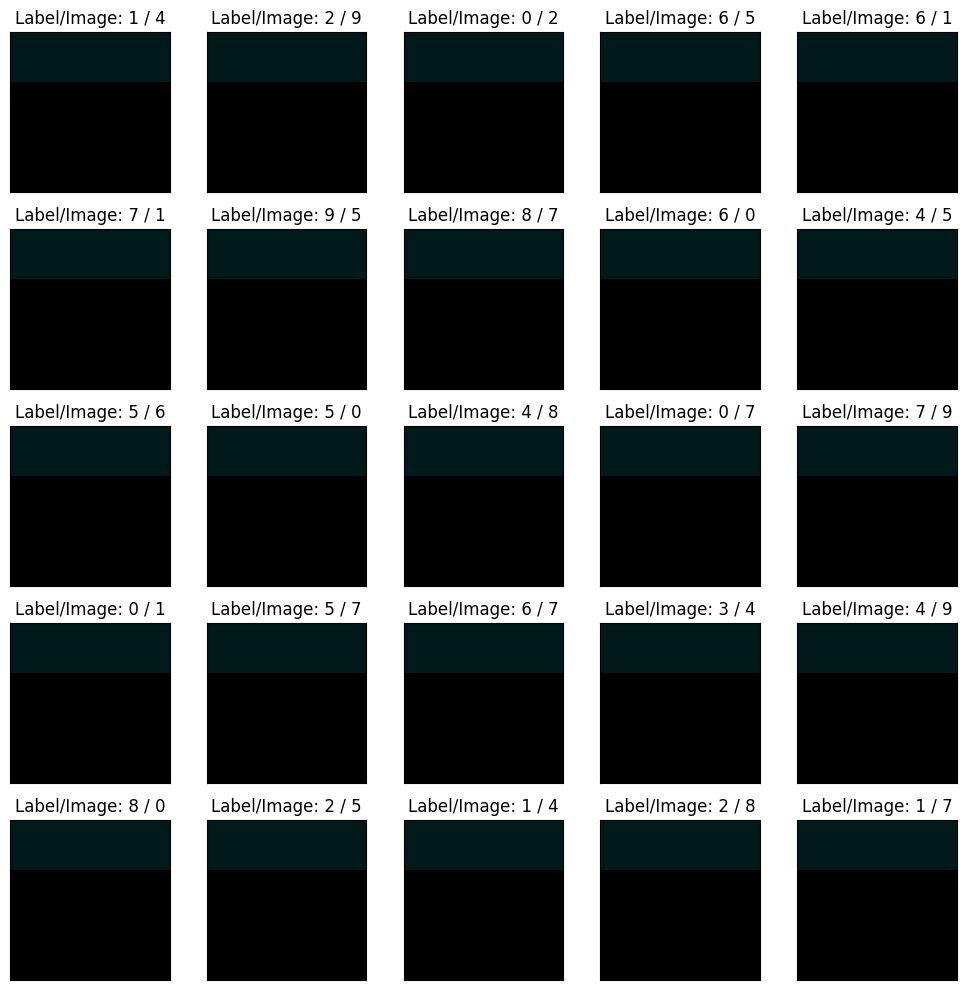

In [14]:
val_batch = next(iter(train_dataloader))
generate_image(val_batch, vae.to('cpu'))

In [ ]:
torch.save(vae, "./vae_cifar.pth")